In [20]:
# importing libraries

import numpy as np
import pandas as pd
import psycopg2 as pg2
import nltk
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.options.display.width  = 1000

In [3]:
# defining functions

def getDataFromDB(query):
    
    try:
        conn = pg2.connect(dbname='twitterDB',user='postgres',password='postgres',host='localhost',port='5432')
        
        if conn.closed ==0:  # checks the system connection is active
            print("Connected to the DB")
            
            cur = conn.cursor()
            
            cur.execute(query)
            records = cur.fetchall()
            
            print("Data fetched")
            
            return records
            
    except Exception as e:
        print("Error thrown")
        print(e)
    
    finally:
        print("Closing connection")
        cur.close()
        conn.close()
        
    

In [4]:
def addTweetLen(df):
    
    df['tweet_len'] = df['clean_tweets'].str.len()
    
    return df

In [5]:
def getDataFrame(val):
    df = pd.DataFrame(val,columns=['index','username','time_created','tweet','retweet_count','place_tweet','location_user'])
    return df    

In [7]:
# Normalizing tweets -> 1)removing non digits,rt,etc 2)Converting to lower 
# Tokenisation
# Lemmatization + removing stopwords

def cleanTweets(df):
    df['clean_tweets'] = None
    
    for idx,i in enumerate(df['tweet']):
        #print(idx,i)
        exclusion_li = ['\W','rt','RT','http','co']
        exclusion_cond = '|'.join(exclusion_li)
        tweet = re.sub(exclusion_cond,' ',i)
        tweet = tweet.lower()
        tweet_words = tweet.split()  
        wnl = nltk.WordNetLemmatizer()
        clean_words = [wnl.lemmatize(i) for i in tweet_words if i not in set(stopwords.words('english'))]
        clean_tweet = ' '.join(clean_words)
        df.loc[idx,'clean_tweets'] = clean_tweet

    return df

In [26]:
def sentimentScore(text):
    
    score = TextBlob(text)
    return score.sentiment.polarity

## Working for All twitter dataset

In [98]:
query1 = 'select * from tweets'

In [99]:
val = getDataFromDB(query1)

Connected to the DB
Data fetched
Closing connection


In [100]:
df = getDataFrame(val)

In [101]:
# Working of fraction of the whole dataset

df = df.sample(frac = 0.1,random_state=101)

In [102]:
df.head()

,index,username,time_created,tweet,retweet_count,place_tweet,location_user
7023,6991,PutraNurfajri,2019-01-16 19:12:59+05:30,Take me somewhere nice,0,Somewhere I belong to,None
143339,143353,Taragolf1,2019-01-18 18:35:34+05:30,RT @SafetyPinDaily: EPA nominee Andrew Wheeler...,0,None,None
85435,85380,Younghoncho,2019-01-18 11:57:53+05:30,RT @RICO_RECKLEZZ: Watevas meant gon happen 🤟🏽💯,0,🌏,None
116382,116367,jxckmin,2019-01-18 17:12:20+05:30,RT @yoongi2seokjoon: [FREEBIES] photocard/stri...,0,None,None
59624,59542,b1kuta,2019-01-18 11:15:59+05:30,Oomf still dragging Ari like he won’t bust to ...,0,None,None


In [103]:
df.reset_index(drop = True,inplace=True) # drop is used to remove the old indexing from adding

In [104]:
df = cleanTweets(df)

In [105]:
df = addTweetLen(df)

In [106]:
df.head()

,index,username,time_created,tweet,retweet_count,place_tweet,location_user,clean_tweets,tweet_len
0,6991,PutraNurfajri,2019-01-16 19:12:59+05:30,Take me somewhere nice,0,Somewhere I belong to,None,take somewhere nice,19
1,143353,Taragolf1,2019-01-18 18:35:34+05:30,RT @SafetyPinDaily: EPA nominee Andrew Wheeler...,0,None,None,safetypindaily epa nominee andrew wheeler read...,97
2,85380,Younghoncho,2019-01-18 11:57:53+05:30,RT @RICO_RECKLEZZ: Watevas meant gon happen 🤟🏽💯,0,🌏,None,rico_recklezz watevas meant gon happen,38
3,116367,jxckmin,2019-01-18 17:12:20+05:30,RT @yoongi2seokjoon: [FREEBIES] photocard/stri...,0,None,None,yoongi2seokjoon freebie photocard strip polaro...,115
4,59542,b1kuta,2019-01-18 11:15:59+05:30,Oomf still dragging Ari like he won’t bust to ...,0,None,None,oomf still dragging ari like bust later,39


In [107]:
df.drop(['index','retweet_count'],axis = 1,inplace = True)

In [108]:
sentiment_score = [sentimentScore(i) for i in df['clean_tweets']]

In [109]:
df['sentiment_score']=sentiment_score

In [110]:
sentiment = [(1 if i>0 else (-1 if i<0 else 0)) for i in df['sentiment_score'] ]

In [111]:
df['sentiment'] = sentiment

In [112]:
wordcloud = WordCloud(background_color='white',width = 2000,height = 1500).generate(" ".join(df['clean_tweets']))

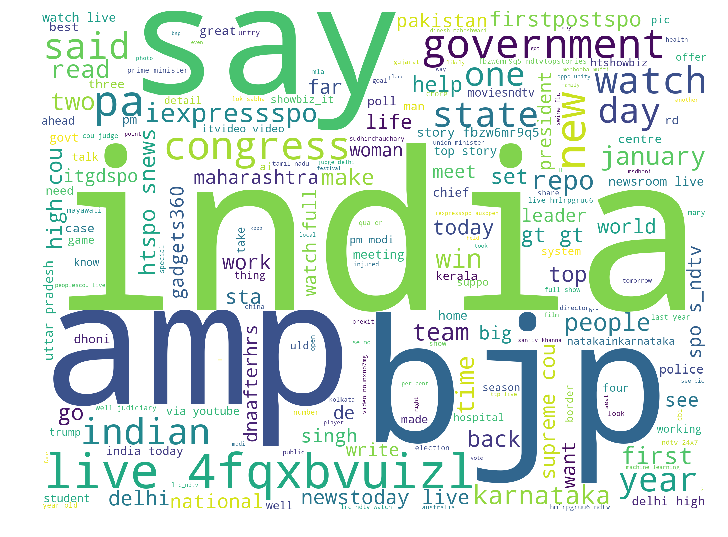

In [142]:
plt.subplots(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Working for my timeline data

In [114]:
query2 = 'select * from timeline_tweets'

In [115]:
val2 = getDataFromDB(query2)

Connected to the DB
Data fetched
Closing connection


In [116]:
df2 = getDataFrame(val2)

In [118]:
df2 = cleanTweets(df2)

In [125]:
df2 = addTweetLen(df2)

In [130]:
df2.head()

,username,time_created,tweet,place_tweet,location_user,clean_tweets,tweet_len
0,goodfellow_ian,2019-01-16 23:05:50+05:30,"RT @colinraffel: New blog post: ""You Don't Kno...","San Francisco, CA",None,linraffel new blog post know jax brief tutoria...,86
1,dna,2019-01-16 23:05:45+05:30,Former NSA MK Narayanan warns on Aadhar inform...,India,None,former nsa mk narayanan warns aadhar informati...,88
2,kdnuggets,2019-01-16 23:05:02+05:30,"Webinar, Jan 30 @InsuranceNexus: QBE, Allstat...","Brookline, MA, USA",None,webinar jan 30 insurancenexus qbe allstate arc...,126
3,htTweets,2019-01-16 23:05:00+05:30,Sikkim opposition parties set for pre-poll all...,India,None,sikkim opposition pa y set pre poll alliance c...,75
4,ndtv,2019-01-16 23:04:29+05:30,.@LRC_NDTV | All's not well in the judiciary?\...,India,None,lrc_ndtv well judiciary watch full show bweiui...,61


In [129]:
df2.drop(['index','retweet_count'],axis = 1,inplace = True)

In [131]:
sentiment_score = [sentimentScore(i) for i in df2['clean_tweets']]

In [133]:
df2['sentiment_score']=sentiment_score

In [135]:
sentiment = [(1 if i>0 else (-1 if i<0 else 0)) for i in df2['sentiment_score'] ]

In [138]:
df2['sentiment'] = sentiment

In [146]:
wordcloud = WordCloud(background_color='white',width = 2000,height = 1500).generate(" ".join(df2['clean_tweets']))

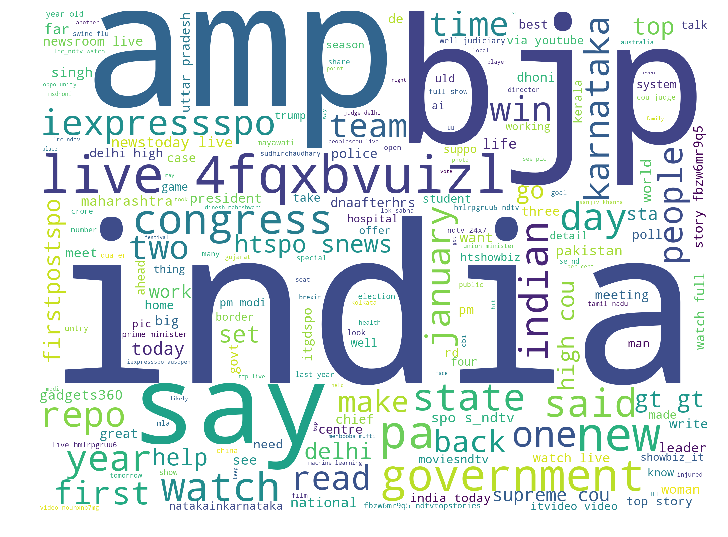

In [148]:
plt.subplots(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Test code

In [ ]:
# df['tweet']


# for i in df['tweet'][:100000]:
#     exclusion_li = ['\W','rt','RT','http','co']
#     exclusion_cond = '|'.join(exclusion_li)
#     tweet = re.sub(exclusion_cond,' ',i)
#     tweet = tweet.lower()
#     tweet_words = nltk.word_tokenize(tweet)  # OR USE split function
#     wnl = nltk.WordNetLemmatizer()
#     clean_words = [wnl.lemmatize(i) for i in tweet_words if i not in set(stopwords.words('english'))]
#     clean_tweet = ' '.join(clean_words)
    
    
# exclusion_li = ['\W','rt','RT','http+','co']
# exclusion_cond = '|'.join(exclusion_li)
# s = 'Take a bow, Ms. Channing'
# test = tweet = re.sub(exclusion_cond,' ',s)
# test = test.lower()
# tweet_words = nltk.word_tokenize(test)
# wnl = nltk.WordNetLemmatizer()
# words = [wnl.lemmatize(i) for i in tweet_words if i not in set(stopwords.words('english'))]
# clean_test = ' '.join(words)
# words